In [58]:
from scipy.linalg import toeplitz
from scipy.signal import convolve
import numpy as np
from matplotlib import pyplot as plt
from matplotlib.lines import Line2D
from scipy.io import loadmat

In [2]:
'''
    Custom autocorrelation function
    
    Iput: Array-like signal
    Output: Input's autocorrelation vector only for positive lags

'''
def autocorr(x):

    a=np.correlate(x,x, mode='full')

    return a[len(x)-1:]


In [3]:
'''
    Custom cross-correlation function
    
    Iput: Two array-like signals
    Output: Input's cross-correlation vector only for positive lags

'''

def corr(x,y):

    a = np.correlate(x,y, mode='full')

    return a[len(x)-1:]

In [99]:
'''
    LMS Implementation
    Input:
        x: Input signal (array-like)
        d: Desired output signal (array-like)
        m: Learning factor (float)
        L: Filter size (Integer)
    Output:
        w: Weight evolution history
        mse: MSE evolution history
'''

def LMS (x,d,m,L):

    x_pad = np.concatenate((np.zeros(L-1),x))


    mse = []
    w=np.zeros(L)
    w = [w]
    e= []

    for i in range(len(x)):
        
        x_n = np.flip(x_pad[i:i+L])

        e = d[i] - np.dot(w[i],x_n)

        w.append(w[i] + m*e*x_n)

        y = convolve(x[:i+1],w[i])[0:len(x[:i+1])]
        
        mse.append(np.mean(e**2))
    

    return (w,mse)


In [98]:
'''
    windowed LMS Implementation
    Input:
        x: Input signal (array-like)
        d: Desired output signal (array-like)
        m: Learning factor (float)
        L: Filter size (integer)
        ws: Window size (integet)
    Output:
        w: Weight evolution history
        mse: MSE evolution history
'''

def wLMS (x,d,m,L,ws):

    x_pad = np.concatenate((np.zeros(L-1),x))

    mse = []
    w = np.zeros(L)
    w = [w]

    for i in range(len(x)-ws):

        y_n = []
        x_n = []
        for j in range(ws):
            x_n.append(np.flip(x_pad[i+j:i+j+L]))
            y_n.append(np.dot(w[i],x_n[j]))
        
        e = d[i:i+ws] - y_n

        
        w.append(w[i] + m*np.dot(e,x_n))
        
        mse.append(np.mean(e**2))
    

    return (w,mse)

In [101]:
'''
    RLS Implementation
    Input:
        x: Input signal (array-like)
        d: Desired output signal (array-like)
        l: Forgetting factor (float)
        delta: Used to initialize matrix P (float)
        L: Filter size (Integer)
    Output:
        w: Weight evolution history
        mse: MSE evolution history
'''

def RLS(x,d,l,delta,L):

    x_pad = np.concatenate((np.zeros(L-1),x))

    w=np.zeros(L)
    w=[w]
    mse=[]
    
    P = [delta * np.identity(L)]
    
    for i in range(len(x)):

        x_n = np.flip(x_pad[i:i+L])

        z = np.matmul(P[i], x_n)

        g = (1/(l + np.dot(x_n,z)))*z

        a = d[i] - np.dot(w[i],x_n)

        w.append(w[i]+ a*z)

        P.append((1/l)*(P[i]-np.outer(g,z)))

        mse.append(np.mean(a**2))

    return(w,mse)
        

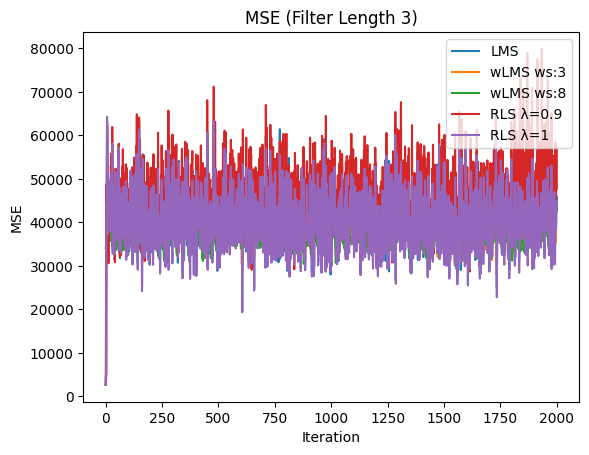

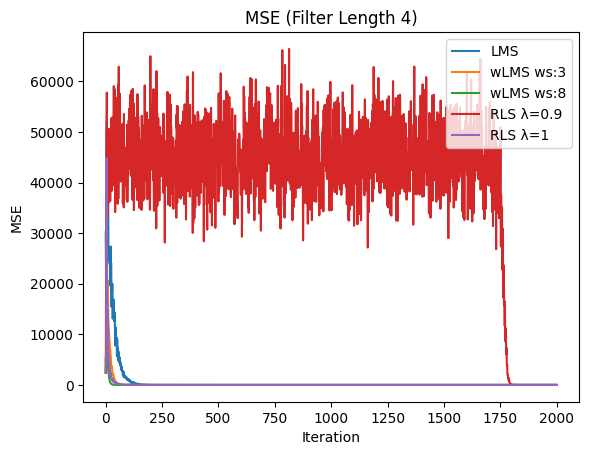

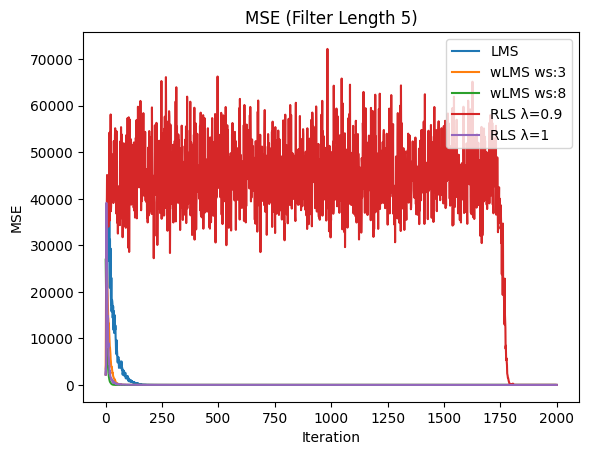

In [141]:
#System's impulse response
h = np.asarray([51, -41.6, -30.73, 200.15])


for L in range(3,6):

    lms_mse =[]
    wlms_mse_1=[]
    wlms_mse_2=[]
    rls_mse_1=[]
    rls_mse_2=[]

    for _ in range(100):

        #Input signal. Gaussian white noise with mean 0 and var 1
        x = np.random.randn(1,2000)[0]

        #Output signal
        d = convolve(x,h)[0:2000]

        #Calculating MSE's for all algorithms
        _, mse = LMS(x,d,0.02,L)
        lms_mse.append(mse)

        _, mse = wLMS(x,d,0.02,L,3)
        wlms_mse_1.append(mse)

        _, mse = wLMS(x,d,0.02,L,8)
        wlms_mse_2.append(mse)

        _,mse = RLS(x,d,0.9,1e-82,L)
        rls_mse_1.append(mse)

        _,mse = RLS(x,d,1,0.15,L)
        rls_mse_2.append(mse)

    #############Plotting################

    plt.title("MSE (Filter Length "+ str(L)+")")
    plt.ylabel("MSE")
    plt.xlabel("Iteration")
    plt.plot(np.mean(lms_mse, axis=0), label="LMS")
    plt.plot(np.mean(wlms_mse_1, axis=0), label="wLMS ws:3")
    plt.plot(np.mean(wlms_mse_2, axis=0), label="wLMS ws:8")
    plt.plot(np.mean(rls_mse_1, axis=0), label="RLS λ=0.9")
    plt.plot(np.mean(rls_mse_2, axis=0), label="RLS λ=1")
    plt.legend(loc="upper right")
    plt.savefig("2_mse_"+str(L)+".png")
    plt.show()

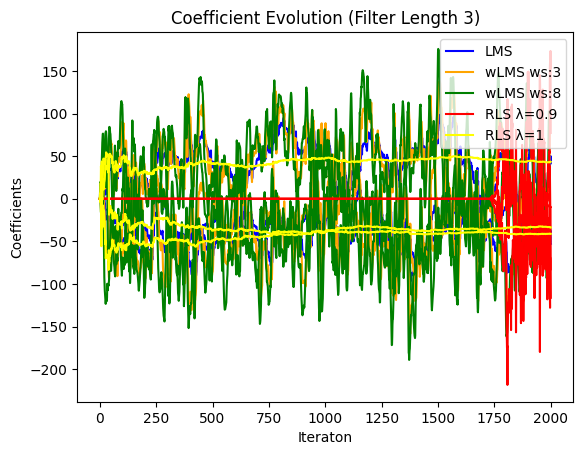

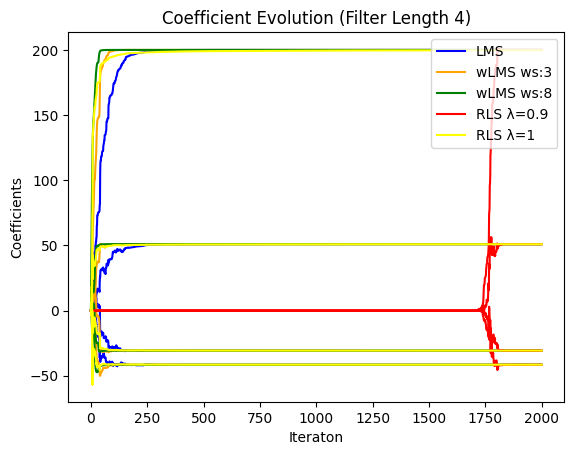

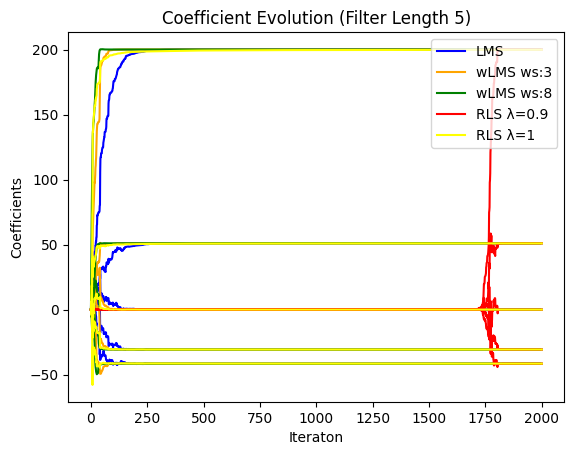

In [142]:
for L in range(3,6):
    w = np.zeros(L)

    #Calculating weights for all algorithms

    weights_lms,_ = LMS(x,d,0.02,L)
    weights_wlms_1,_ = wLMS(x,d,0.02,L,3)
    weights_wlms_2,_ = wLMS(x,d,0.02,L,8)
    weights_rls_1,_ = RLS(x,d,0.9,1e-82,L)
    weights_rls_2,_ = RLS(x,d,1,0.15,L)



    ######################Plotting###########################

    plt.title("Coefficient Evolution (Filter Length "+ str(L)+")")
    plt.ylabel("Coefficients")
    plt.xlabel("Iteraton")
    plt.plot(weights_lms, color="blue", label="LMS")
    plt.plot(weights_wlms_1, color="orange", label="wLMS ws:3")
    plt.plot(weights_wlms_2, color="green", label="wLMS ws:8")
    plt.plot(weights_rls_1, color="red", label="RLS λ=0.9")
    plt.plot(weights_rls_2, color="yellow", label="RLS λ=1")

    # Create a custom legend with correct colors
    legend_elements = [Line2D([0], [0], color="blue", label="LMS"),
                   Line2D([0], [0], color="orange", label="wLMS ws:3"),
                   Line2D([0], [0], color="green", label="wLMS ws:8"),
                   Line2D([0], [0], color="red", label="RLS λ=0.9"),
                   Line2D([0], [0], color="yellow", label="RLS λ=1")]

    # Place the legend in the upper right corner
    plt.legend(handles=legend_elements, loc="upper right")
    plt.savefig("2_weights_"+str(L)+".png")
    plt.show()
    

In [7]:
'''
    Weiner-Hopf calculator
    Input:
        x: Input signal (array-like)
        d: Desired output signal (array-like)
        L: Filter size (Integer)
    Output:
        w: Optimal weights calculated
'''

def weiner_hopf(x,y,L):
    r_x = autocorr(x)[:L]
    R_x = toeplitz(r_x)
    r_dx =corr(y,x)[:L]

    w = np.matmul(np.linalg.inv(R_x),r_dx)

    return w

In [147]:
x = loadmat('x.mat')['data']
d = loadmat('d.mat')['data']

weights=[]

for input, output in zip(x,d):
    weights.append(weiner_hopf(input,output,3))

mean_weights = np.mean(weights, axis=0)
print("Weiner-Hopf results:")
print("w1 = "+str(mean_weights[0]))
print("w2 = "+str(mean_weights[1]))
print("w3 = "+str(mean_weights[2]))

Weiner-Hopf results:
w1 = -0.012141145052683353
w2 = -41.37560059833335
w3 = -30.541243646681977


In [118]:
lms_weights=[]
lms_mse=[]

for input,output in zip(x,d):
    w,mse = LMS(input,output,0.02,3)

    lms_mse.append(mse)
    lms_weights.append(w)

lms_mean_weights=np.mean(lms_weights,axis=0)
lms_mean_mse=np.mean(lms_mse,axis=0)


In [157]:
lms_mean_weights[1994]

array([-50.99999982, -41.59999998, -30.72999995])

In [154]:
wlms_weights=[]
wlms_mse=[]

for input,output in zip(x,d):
    w,mse = wLMS(input,output,0.02,3,8)

    wlms_mse.append(mse)
    wlms_weights.append(w)

wlms_mean_weights=np.mean(wlms_weights, axis=0)
wlms_mean_mse=np.mean(wlms_mse, axis=0)

/home/zisissour/Dropbox/Stochastic Signals/Code/.venv/lib/python3.8/site-packages/numpy/core/_methods.py:181: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(arr, axis, dtype, out, keepdims, where=where)
/tmp/ipykernel_13776/3703797622.py:28: RuntimeWarning: overflow encountered in square
  mse.append(np.mean(e**2))
/tmp/ipykernel_13776/3703797622.py:23: RuntimeWarning: invalid value encountered in add
  w.append(w[i] + m*np.dot(e,x_n))


In [138]:
rls_weights=[]
rls_mse=[]

for input,output in zip(x,d):
    w,mse = RLS(input,output,1,0.15,3)

    rls_mse.append(mse)
    rls_weights.append(w)

rls_mean_weights=np.mean(rls_weights, axis=0)
rls_mean_mse=np.mean(rls_mse, axis=0)

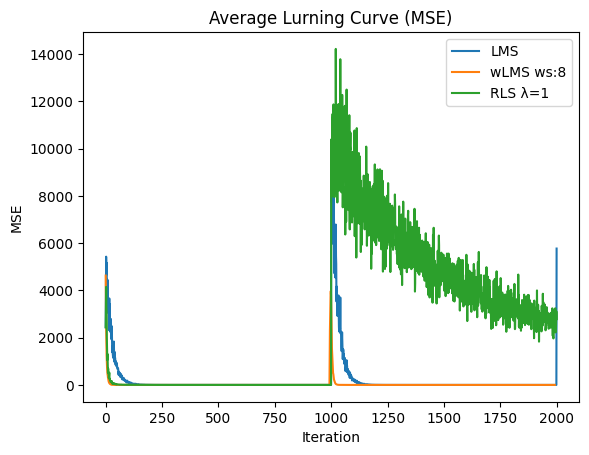

In [144]:
plt.title("Average Lurning Curve (MSE)")
plt.xlabel("Iteration")
plt.ylabel("MSE")
plt.plot(lms_mean_mse, label="LMS")
plt.plot(wlms_mean_mse, label="wLMS ws:8")
plt.plot(rls_mean_mse, label="RLS λ=1")
plt.legend(loc="upper right")
plt.savefig("3_mse.png")
plt.show()

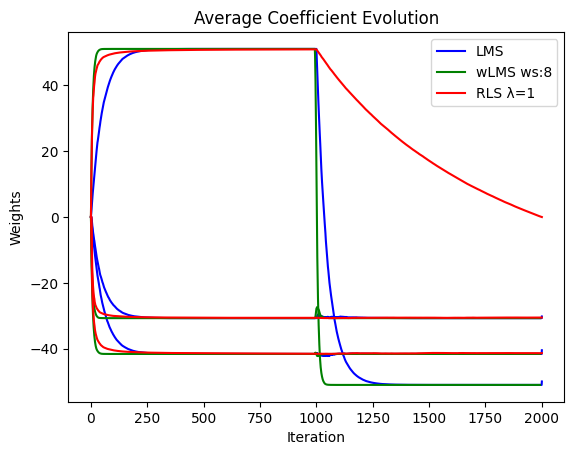

In [145]:
plt.title("Average Coefficient Evolution")
plt.ylabel("Weights")
plt.xlabel("Iteration")

plt.plot(lms_mean_weights, color="blue", label="LMS")
plt.plot(wlms_mean_weights, color="green", label="wLMS ws:8")
plt.plot(rls_mean_weights, color="red", label="RLS λ=1")

legend_elements = [Line2D([0], [0], color="blue", label="LMS"),
                   Line2D([0], [0], color="green", label="wLMS ws:8"),
                   Line2D([0], [0], color="red", label="RLS λ=1")]

plt.legend(handles=legend_elements, loc="upper right")
plt.savefig("3_weights.png")
plt.show()